TODO: 
* modify pipeline, more options
* test data as whole, not couple of chunks
* visualisation for diagnosing


Architectures:
* conv2d
* cnn + lstm: https://stats.stackexchange.com/questions/252095/sequence-classification-via-neural-networks

In [22]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [23]:
from IPython.core.debugger import set_trace

import numpy as np

#display all values from array
np.set_printoptions(threshold=np.nan)
#display not in scientific format
np.set_printoptions(suppress=True)

import math

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, BatchNormalization, Activation
from keras.optimizers import RMSprop, SGD, Adam
from keras import callbacks
from keras.constraints import maxnorm

from sklearn.model_selection import train_test_split, StratifiedKFold

CHUNK_SIZE_IN_SECONDS = 4

In [25]:
from time import time
import datetime

def create_current_time():
    timestamp = time()
    return datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [26]:
def callbacks_list(description): 
    return [
    callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10
    ),
    callbacks.ModelCheckpoint(
        filepath='tmp/best_model.h5', 
        monitor='val_loss', 
        save_best_only=True
    ),
    callbacks.TensorBoard(
        log_dir='tmp/logs/{}:{}'.format(description, create_current_time()),
        histogram_freq=0, #it has to be 0, otherwise throws error during training
        write_graph=True,
        write_images=True
    )
]

In [27]:
import inspect

def get_function_name():
    return inspect.stack()[1][3]

In [28]:
from data_reader import get_data

def load_data_kfold(folds_number):
    x, y = get_data(CHUNK_SIZE_IN_SECONDS)
    
    x_train, x_test, y_train, y_test = train_test_split(x, 
                                                        y, 
                                                        test_size=0.05)
    
    folds = list(StratifiedKFold(n_splits=folds_number, 
                                 shuffle=True, 
                                 random_state=1).split(x, y))
    
    return folds, x, y

def load_data_train_test(test_size=0.05):
    x, y = get_data(CHUNK_SIZE_IN_SECONDS)
    
    x_train, x_test, y_train, y_test = train_test_split(x, 
                                                        y, 
                                                        test_size=test_size)
    
    return x_train, y_train, x_test, y_test

In [29]:
def run_pipeline(create_model, folds, x, y, epochs):
    score = []
    best_model_score = []
    
    for fold_number, (train_idx, val_idx) in enumerate(folds):
        print('\nFold: ', fold_number + 1)
        x_train_cv = x[train_idx]
        y_train_cv = y[train_idx]
        x_valid_cv = x[val_idx]
        y_valid_cv = y[val_idx]
                
        input_shape = x.shape[1:]

        model, model_description = create_model(input_shape)
        
#         todo:
        description = ""

        callbacks = callbacks_list("{}. {}-{}".format(model_description, 
                                                      description, 
                                                      fold_number))

        history = model.fit(x_train_cv,
                            y_train_cv,
                            epochs=epochs,
                            batch_size=16,
                            callbacks=callbacks,
                            validation_data=(x_valid_cv, y_valid_cv),
                            verbose=0)

        score.append(model.evaluate(x_valid_cv, y_valid_cv, batch_size=16, verbose=0))

        model.load_weights("tmp/best_model.h5")
        best_model_score.append(model.evaluate(x_valid_cv, y_valid_cv, batch_size=16, verbose=0))
        
        print("--Last epoch validation accuracy: %.2f%%" % (score[fold_number][1]*100))
        print("--Best model validation accuracy: %.2f%%" % (best_model_score[fold_number][1]*100))
        
    return score, best_model_score

In [30]:
folds, x, y = load_data_kfold(folds_number=10)

# x_train, y_train, x_test, y_test = load_data_train_test()

In [31]:
# ~70-80% test, overfitting
def conv_1D_62_32(input_shape):
    description = get_function_name()
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=RMSprop(lr=3e-5),
                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description

#less overfitting
def conv_1D_smaller_32_16(input_shape):
    description = get_function_name()
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=16, kernel_size=6, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=RMSprop(lr=3e-5),
                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description


# bad
def cnn_lstm(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=16, kernel_size=6, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(100))
    
#     model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=RMSprop(lr=3e-5),
                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description


def baseline(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(60, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model, description


def testing(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=16, kernel_size=6, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
#     lr=3e-5
    model.compile(optimizer=Adam(),                  
                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description

In [32]:
model = testing

number_of_iterations = 2

avg_accuracies = []
std_accuracies = []

for iteration in range(0, number_of_iterations):
    iteration_number = iteration + 1 
    print("Iteration", iteration_number)
    start_time = time()
    
    score, best_model_score = run_pipeline(create_model=model,
                                           folds=folds,
                                           x=x,
                                           y=y,
                                           epochs=300)

    print("\n")
    accuracy = [row[1] for row in best_model_score]

    avg_accuracy = np.mean(accuracy)
    print("Best models average validation accuracy: {}".format(avg_accuracy))

    std_accuracy = np.std(accuracy)
    print("Best models standard deviation of accuracy: {}".format(std_accuracy))
    
    avg_accuracies.append(avg_accuracy)
    std_accuracies.append(std_accuracy)
    
    print("Iteration", iteration_number, "time:", time() - start_time, "seconds")
    print("\n")
    
    
print("~~~Grand mean of average accuracy: {}".format(np.mean(avg_accuracies)))
print("~~~Grand mean of standard deviation accuracy: {}".format(np.mean(std_accuracies)))

Iteration 1

Fold:  1
--Last epoch validation accuracy: 72.03%
--Best model validation accuracy: 72.03%

Fold:  2
--Last epoch validation accuracy: 84.75%
--Best model validation accuracy: 81.36%

Fold:  3
--Last epoch validation accuracy: 81.36%
--Best model validation accuracy: 82.20%

Fold:  4
--Last epoch validation accuracy: 74.58%
--Best model validation accuracy: 73.73%

Fold:  5
--Last epoch validation accuracy: 79.66%
--Best model validation accuracy: 78.81%

Fold:  6
--Last epoch validation accuracy: 74.58%
--Best model validation accuracy: 76.27%

Fold:  7
--Last epoch validation accuracy: 68.64%
--Best model validation accuracy: 75.42%

Fold:  8
--Last epoch validation accuracy: 76.27%
--Best model validation accuracy: 81.36%

Fold:  9
--Last epoch validation accuracy: 78.45%
--Best model validation accuracy: 83.62%

Fold:  10
--Last epoch validation accuracy: 75.86%
--Best model validation accuracy: 75.00%


Best models average validation accuracy: 0.779807130636213
Best m

In [33]:
def plot_results(history):
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
# plot_results(history)
# using view in tensorboard instead

In [34]:
from plots_printer import draw_plots, draw_plots_with_chunks
from data_reader import load_input_data, prepare_chunks

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

FREQUENCY_TO_SAMPLING_RATIO = 100

input_data, target, headers = load_input_data()
chunks_input, chunks_target = prepare_chunks(input_data, 
                                            target, 
                                            chunk_size_in_seconds=CHUNK_SIZE_IN_SECONDS, 
                                            ratio=FREQUENCY_TO_SAMPLING_RATIO)

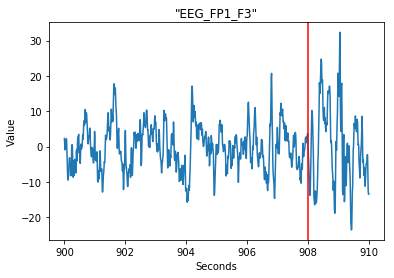

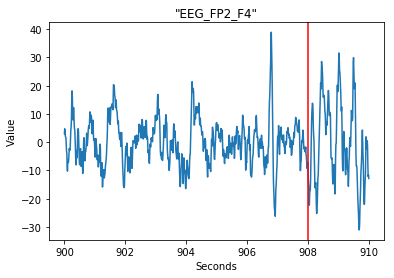

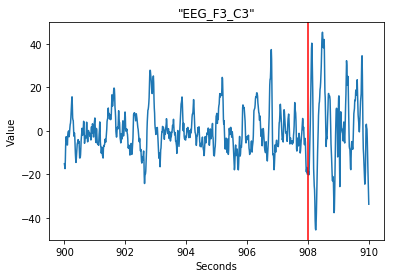

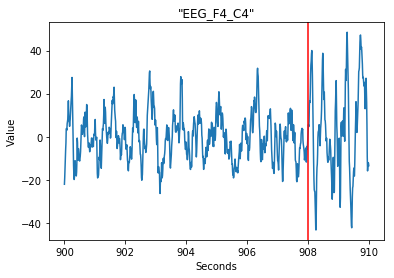

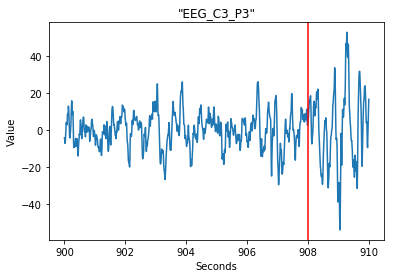

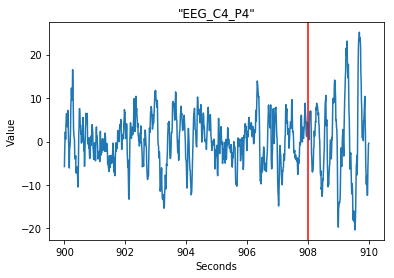

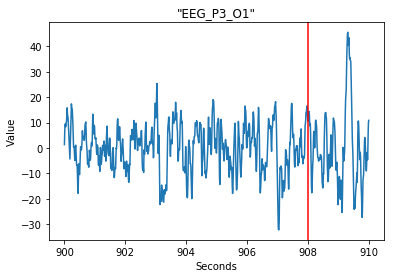

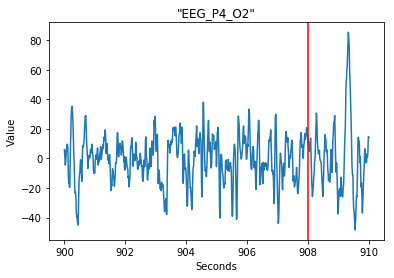

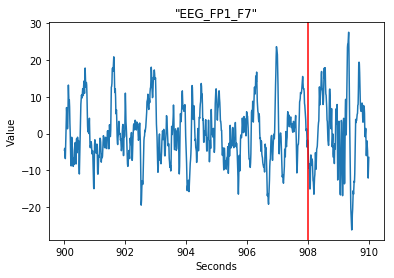

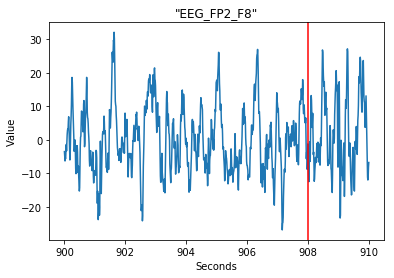

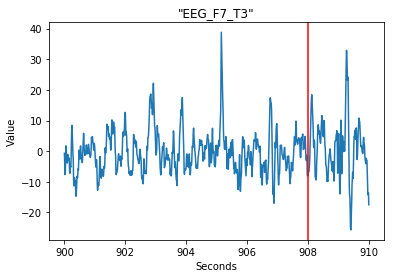

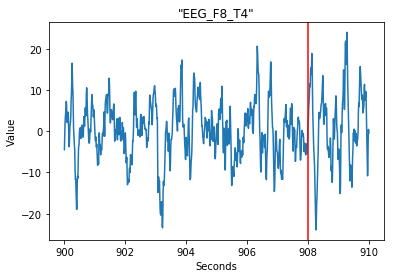

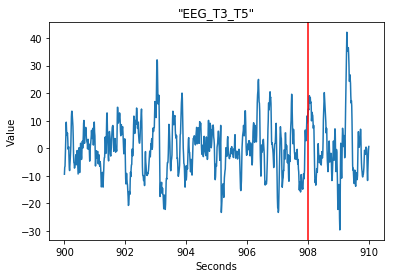

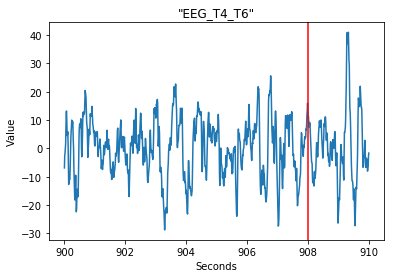

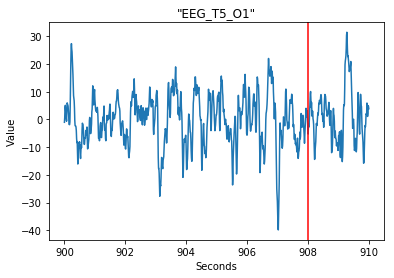

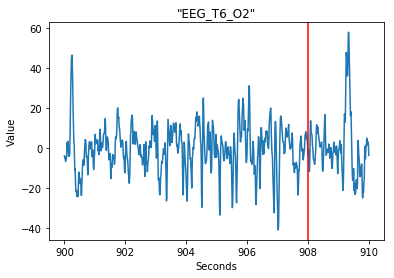

In [35]:
draw_plots(input_data, 
           target, 
           headers, 
           patient=0, 
           start_second=900, 
           end_second=910,
           ratio=FREQUENCY_TO_SAMPLING_RATIO)

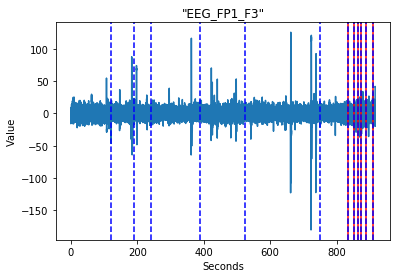

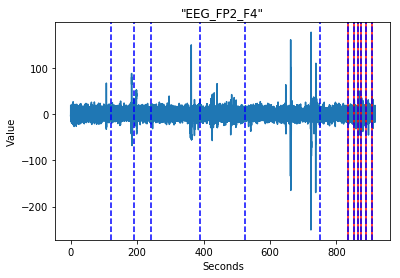

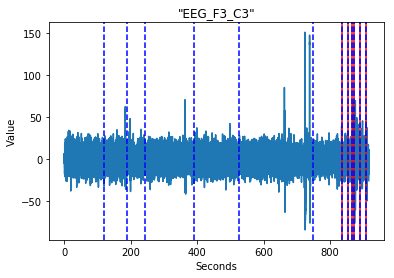

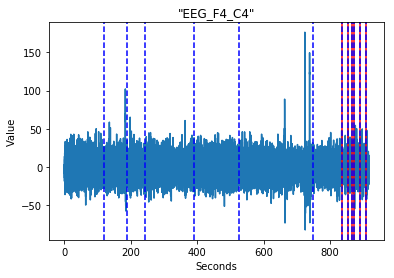

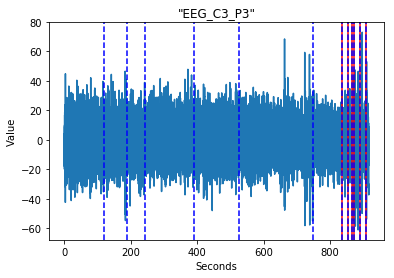

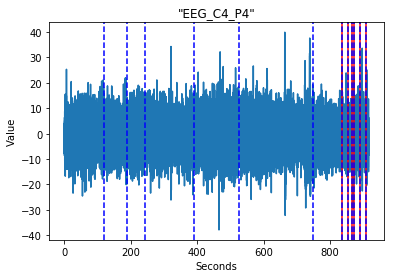

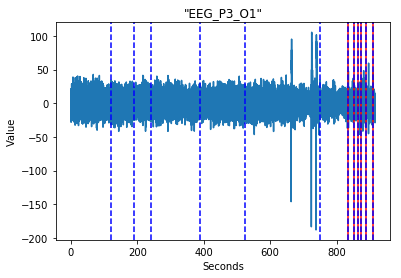

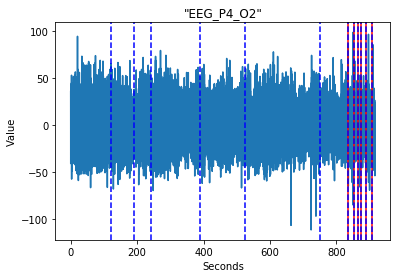

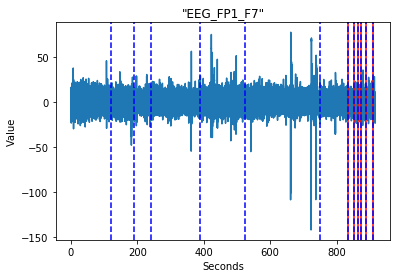

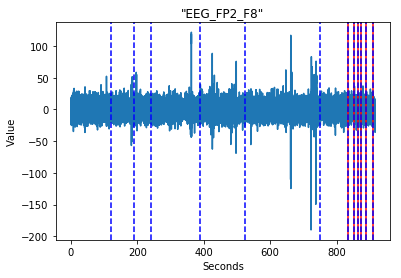

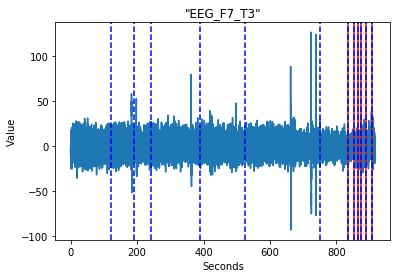

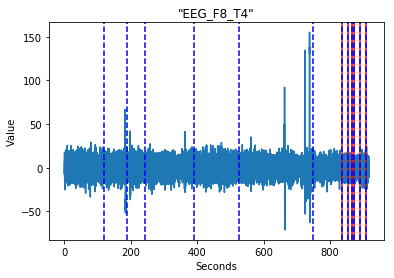

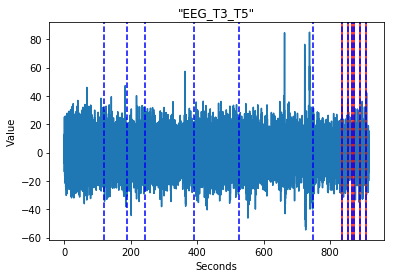

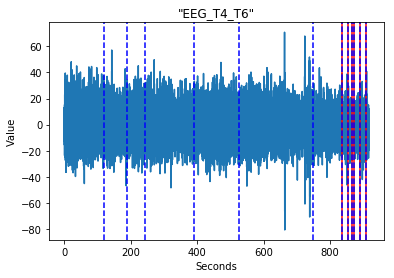

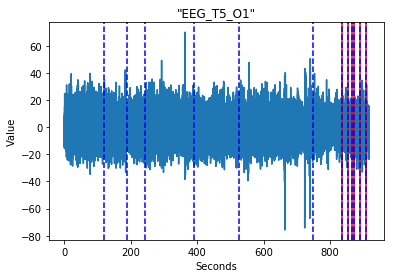

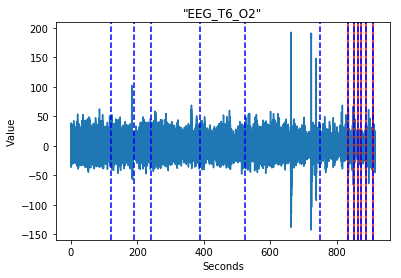

In [36]:
draw_plots_with_chunks(input_data, target, headers, patient=0, chunks_input = chunks_input, to_pdf=False)